*This notebook can be found on* [github](https://github.com/bastikr/QuantumOptics.jl/blob/master/examples/particle-in-harmonic-trap.ipynb)

Particle in harmonic trap potential
===================================

A particle in a harmonic trap is described by a Hamiltonian of the form
$$
    H = \frac{\hat{p}^2}{2m} + \frac{1}{2}m \omega^2 \hat{x}^2
$$

For numerical simulations we are forced to work in a basis. For particles there are two common choices. We can either work in real space or alternatively in momentum space.

In [1]:
using QuantumOptics
using PyPlot

In [2]:
# System Parameters
m = 1.
ω = 0.5 # Strength of trapping potential;

In [3]:
# Position Basis
xmin = -5
xmax = 5
Npoints = 100
b_position = PositionBasis(xmin, xmax, Npoints)

# Hamiltonian in real space basis
p = momentumoperator(b_position)
x = positionoperator(b_position)

H = p^2/2m + 1/2*m*ω^2*x^2;

Of course we could also choose to work in momentum space:

From a PositionBasis **QuantumOptics.jl** can automatically infere the corresponding MomentumBasis by calculating $p_\mathrm{min} = -\pi/dx$ and $p_\mathrm{max} = \pi/dx$ where $dx = (x_\mathrm{max} - x_\mathrm{min})/N$

In [4]:
b_momentum = MomentumBasis(b_position);

# Hamiltonian
p = momentumoperator(b_momentum)
x = positionoperator(b_momentum)

H = p^2/2m + 1/2*m*ω^2*x^2;

However, both choices are not optimal since in real space the position operator is diagonal while the momentum operator is a completely dense matrix and vice versa for the momentum space. Therefore, the calculation will scale with $N^2$ where $N$ is the dimension of the Hilbert space. A commonly used trick is to utilize fast Fourier transformation to convert the state of the system between real and momentum space. This allows us to always use the diagonal form of the operators which all in all speeds up the calculations to $N \log N$.

This idea is implemented by the FFTOperator which performs a fast Fourier transformation on the multiplied state.

In [5]:
# Transforms a state multiplied from the right side from real space
# to momentum space.
op_fft = particle.FFTOperator(b_momentum, b_position);

To use this operator in a Hamiltonian we additionally need the concept of lazy operators which allow us to delay certain operations to a later point in the simulation. E.g. the LazyProduct allows us to do $A*(B*x)$ instead of $(A*B)*x$ which means for our case that the matrix-matrix product never has to be calculated directly but only two matrix-vector multiplications instead.

In [6]:
op_inversefft = dagger(op_fft)

x = positionoperator(b_position)
p = momentumoperator(b_momentum)

H = LazyProduct(op_inversefft, p^2/2m, op_fft) + ω*x^2;

Finally we can simulate the time evolution according to a Schroedinger equation.

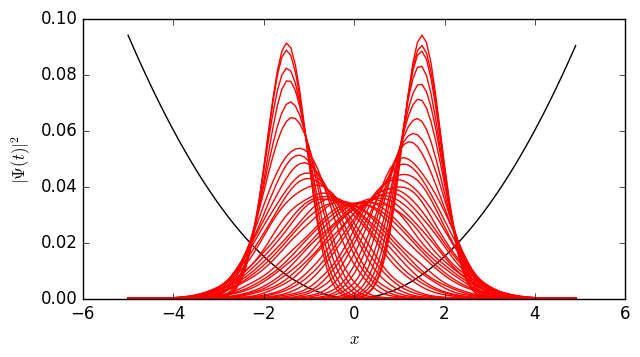

In [7]:
# Initial state
x0 = 1.5
p0 = 0
sigma0 = 0.6
Ψ0 = gaussianstate(b_position, x0, p0, sigma0);

# Time evolution
T = [0:0.5:20;]
tout, Ψt = timeevolution.schroedinger(T, Ψ0, H);

# Plot dynamics of particle density
x_points = particle.samplepoints(b_position)

n = abs(Ψ0.data).^2
V = ω*x_points.^2
C = maximum(V)/maximum(n)

figure(figsize=(7,3.5))
xlabel(L"x")
ylabel(L"| \Psi(t) |^2")
plot(x_points, V/C, "k")

for Ψ=Ψt
    n = abs(Ψ.data).^2
    plot(x_points, n, "r")
end;